In [1]:
from pinecone_text.sparse import SpladeEncoder
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os
import pandas as pd
from PIL import Image
import nltk
from dotenv import load_dotenv

load_dotenv()
nltk.download('punkt_tab')

/home/lavender/02_SaleChatbot/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lavender/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
FIREWORKS_API_KEY = os.getenv("FIREWORKS_API_KEY")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

INDEX_NAME = "salechatbot"

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pass
else:
    pinecone.create_index(
    INDEX_NAME,
    dimension=512,
    metric="dotproduct",
    spec=ServerlessSpec(cloud='aws', region='us-east-1')
    )
index = pinecone.Index(INDEX_NAME)

cuda


In [4]:
if os.path.exists("crawl_data_code/data/products.csv"):
    data = pd.read_csv("crawl_data_code/data/products.csv")
    
else:
    data = pd.read_json("crawl_data_code/data/products.jsonl", lines=True).sort_values(by="id")
    files = os.listdir("crawl_data_code/data/images")
    data = data[data["id"].isin([int(file.split(".")[0]) for file in files])]
    data["quantity_sold"] = data["quantity_sold"].progress_apply(lambda x: x["value"] if x else x)
    data.to_csv("crawl_data_code/data/products.csv", index=False)

images = [Image.open(f"crawl_data_code/data/images/{file}.jpg") for file in data["id"]]
data.replace(pd.NA, "", inplace=True)
data = data.astype("string")

In [5]:
splade = SpladeEncoder()
splade.encode_documents([data["name"].iloc[0]])

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[{'indices': [1011,
   1048,
   2002,
   2193,
   2208,
   2213,
   2232,
   2299,
   2368,
   2377,
   2399,
   2447,
   2487,
   2544,
   2806,
   2839,
   2859,
   2900,
   2944,
   3042,
   3101,
   3153,
   3282,
   3410,
   3422,
   3578,
   3608,
   3642,
   4003,
   4290,
   4471,
   4578,
   4601,
   4967,
   5195,
   5413,
   5689,
   6028,
   6085,
   6454,
   6504,
   6865,
   7221,
   7317,
   7917,
   8164,
   8928,
   9121,
   10658,
   11865,
   13569,
   17137,
   20222,
   20421,
   23632],
  'values': [0.08501353114843369,
   0.8620956540107727,
   0.13536079227924347,
   0.40568816661834717,
   1.4305161237716675,
   0.9070180058479309,
   0.8002436757087708,
   0.19163456559181213,
   0.1911483108997345,
   0.04120612516999245,
   0.7546883821487427,
   0.20374543964862823,
   0.3527631163597107,
   0.1337498426437378,
   0.1303468942642212,
   0.44536975026130676,
   0.28587645292282104,
   0.20035415887832642,
   0.25102731585502625,
   0.48322099447250366,
   0.

In [6]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', 
    device=device)

In [7]:
model.encode([images[0]]).shape

(1, 512)

In [8]:
batch_size = 100
fashion_data_num = 10000

for i in tqdm(range(0, min(fashion_data_num, len(data)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(data))
    # extract metadata batch
    meta_batch = data.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [str(x) for _, x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'sku', 'seller_id', 'seller_product_id', 'thumbnail_url'])].iterrows()]
    meta_dict = [
            {"context": context, **metadata}
            for context, metadata in zip(meta_batch, meta_dict)
        ]
    
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse splade vectors
    sparse_embeds = splade.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta, content in zip(ids, sparse_embeds, dense_embeds, meta_dict, meta_batch):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)
# show index description after uploading the documents
index.describe_index_stats()

100%|██████████| 56/56 [04:36<00:00,  4.94s/it]


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 11050}},
 'total_vector_count': 11050}

In [19]:
query = "bàn phím gaming."

sparse = splade.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=280x280>]

In [20]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


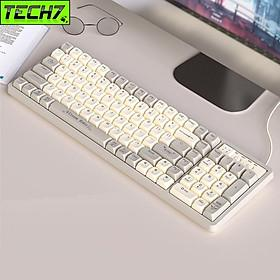
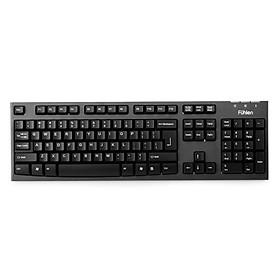
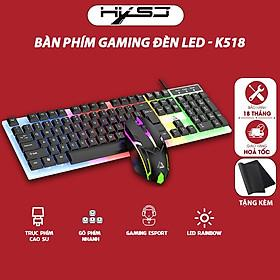
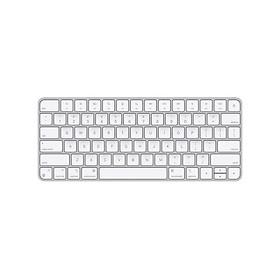
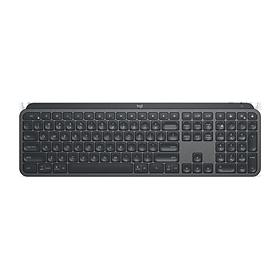
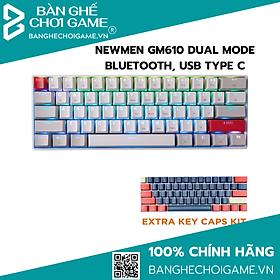
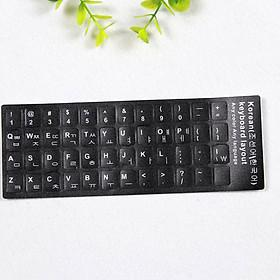
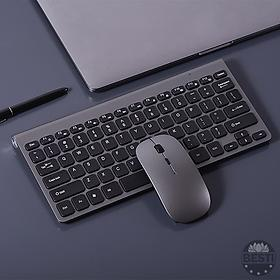
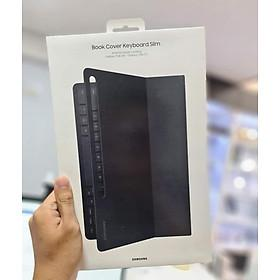
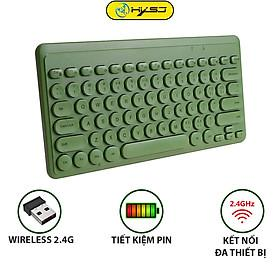
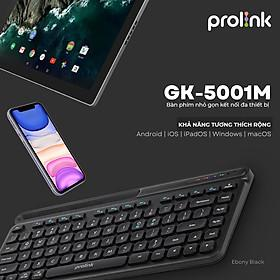
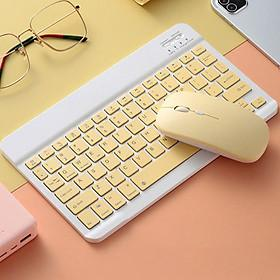
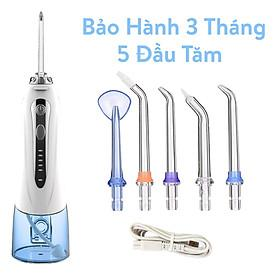
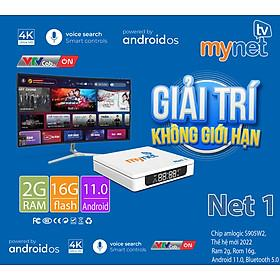

In [21]:
display_result(imgs)

### Scaling the Hybrid Search

In [22]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

### 1. More Dense


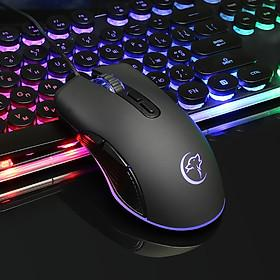
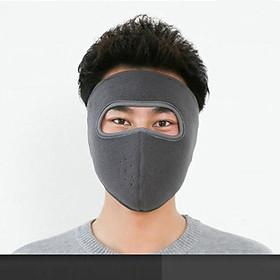
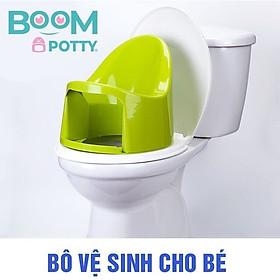
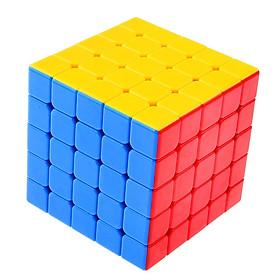
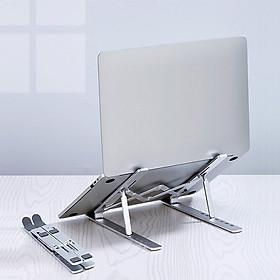
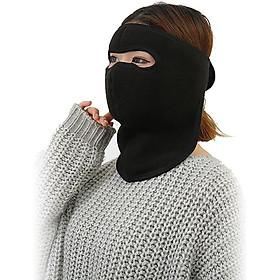

In [23]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [24]:
for x in result["matches"]:
    print(x["metadata"]['name'])

Chuột led Ghost Wolf G830 cho máy tính - hàng nhập khẩu
Khẩu trang ninja vải nỉ kính che kín mặt kín tai chống nắng gió lạnh bụi - khau trang kinh che kin
Bô Vệ Sinh Thông Minh Boom Potty
Rubik 5x5 cao cấp
Giá Đỡ Laptop Hợp Kim Nhôm Cao Cấp Có Thể Gấp Gọn - Đế Tản Nhiệt Laptop - Macbook, Máy Tính Xách Tay - 07 Vị Trí Điều Chỉnh Góc Độ - Hàng Chính Hãng - VinBuy
Bộ 2 khẩu trang ninja che cổ dán gáy vải nỉ chống nắng gió bụi hàn xì thích hợp cả nam và nữ - khau trang ninja che co dan gay chong nang


### 2. More Sparse


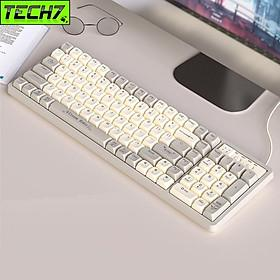
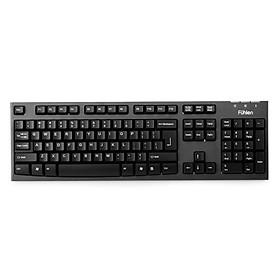
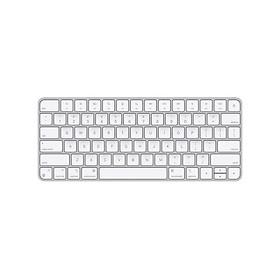
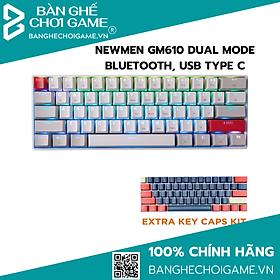
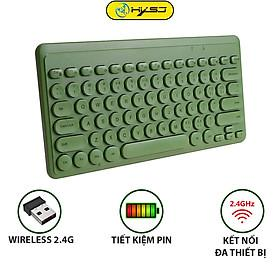
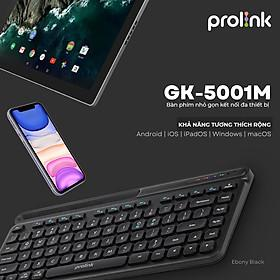

In [25]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [26]:
for x in result["matches"]:
    print(x["metadata"]['name'])

Bàn Phím Cơ Gaming dây usb GK102 Hotswap chống ồn cho máy tính laptop hàng nhập khẩu
Bàn Phím Game Fuhlen L411 - Hàng Chính Hãng
Bàn phím Magic Keyboard Apple MK2A3 (US keyboard)
Bàn phím cơ không dây Newmen GM610 - Hàng chính hãng
Bàn phím không dây HXSJ K610 USB2.4G giảm ồn, gọn nhẹ dễ mang đi, phù hợp PC/ Laptop/ Điện thoại- Hàng chính hãng
Bàn phím không dây Bluetooth + Wireless PROLiNK GK5001M, nhỏ gọn, kết nối đa thiết bị Windows/Android/MacOS/iOS - Hàng chính hãng


### More Dense or More Sparse?


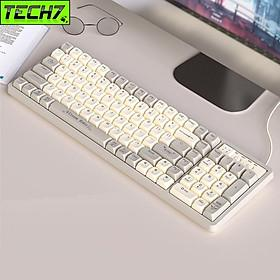
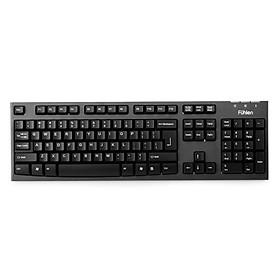
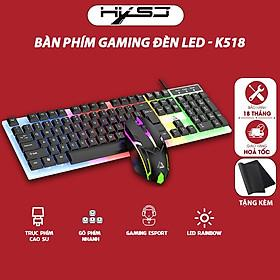
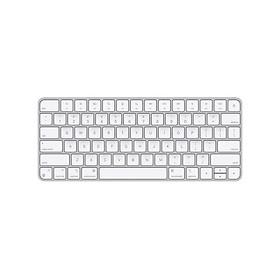
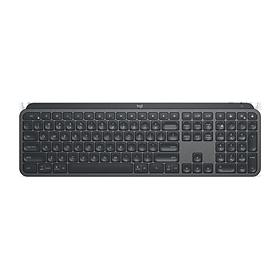
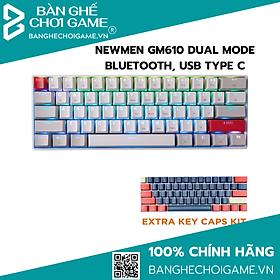

In [27]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [28]:
for x in result["matches"]:
    print(x["metadata"]['name'])

Bàn Phím Cơ Gaming dây usb GK102 Hotswap chống ồn cho máy tính laptop hàng nhập khẩu
Bàn Phím Game Fuhlen L411 - Hàng Chính Hãng
Bàn phím giả cơ K518 kèm chuột, bàn phím máy tính chống nước led rgb chơi game làm việc văn phòng cho PC laptop - hàng chính hãng
Bàn phím Magic Keyboard Apple MK2A3 (US keyboard)
Bàn phím không dây Bluetooth Logitech MX Keys - đa thiết bị, sạc nhanh, Mac/ PC -Hàng chính hãng
Bàn phím cơ không dây Newmen GM610 - Hàng chính hãng
